# Detection Phase (INT & RSSI)를 이용한 모델에서의 성능 평가

### Data

* **Distance**
    * Distance between the Tag and the Attacker
    * 0m, 1m, 2m


* **Number of Data**
    * Number of Data for Spoofing Attack Detection Prediction
    * 50개, 100개, 500개
    
    
* **Packet Speed**
    * Speed of the Beacon Data the Anchor Point receives
    * Average Time Interval of **Fast** (0.03ms), **Normal** (0.13ms), **Slow** (0.35ms)
  
  
* 총 27가지 상황의 데이터 수집
    * 각 상황에 따라 100개의 파일로 수집
    * 결론적으로 2700개의 데이터 파일 수집

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import Holt

In [2]:
# Confidence Interval
class Confidence():
    def __init__(self, z, holt_z):
        self.z = z  # 2.58, 99%의 신뢰구간
        self.holt_z = holt_z # 3.219, 99.9%의 신뢰구간
    
    # 다음 수신 시간 간격 값을 예측하는데 방해되는 불안정한 데이터 수집 방지
    def confidenceInterval(self, use_INT_arr):
        return np.mean(use_INT_arr) + ( self.z * (np.std(use_INT_arr) / np.sqrt(len(use_INT_arr))) )

    # 예측값을 기반으로 다음 수신 시간 간격의 하한값을 계산
    def holtLower(self, fcast, se):
        return fcast - ( self.holt_z * se )

In [3]:
# Holt's Method
class HoltMethod():
    def __init__(self, a):
        self.a = a # 0.1
    
    # 다음 수신 시간 간격 값을 예측
    def holtForcast(self, use_INT_arr):
        if len(use_INT_arr) < 10:
            count = 10 - len(use_INT_arr)
            
            for i in range(count):
                use_INT_arr.append(use_INT_arr[i])
                
        fit = Holt(use_INT_arr, initialization_method="estimated").fit(smoothing_level=self.a)
        return fit.forecast(1)[0]

In [4]:
# Time Interval
class INT():
    def __init__(self, testCase, mini_range):
        self.use_INT_arr = []
        self.pre_time = 0
        self.fcast = 0
        self.power_sum = 0
        self.se = 0
        self.idx = 2
        self.testCase = testCase
        self.mini_range = mini_range

        self.confi = Confidence(z = 2.58, holt_z= 3.219)
        self.holt = HoltMethod(a = 0.1)

    def full_arr(self):
        del self.use_INT_arr[:len(self.use_INT_arr) - 100]

    def check_INT(self, curr_time, test):
        if len(self.use_INT_arr) > 10000:
            self.full_arr()

        if self.pre_time == 0:
            self.pre_time = curr_time
            return False

        # 수신 시간 간격 계산
        INT = curr_time - self.pre_time

        if len(self.use_INT_arr) < 3 and INT < self.mini_range:
            self.use_INT_arr.append(INT)
            self.pre_time = curr_time
            return False

        # 계산된 수신 시간 간격이 신뢰 구간에 속하는지 검사
        if INT < self.confi.confidenceInterval(self.use_INT_arr):
            if len(self.use_INT_arr) > self.testCase :

                if self.fcast == 0:
                    self.fcast = self.holt.holtForcast(self.use_INT_arr)
                    self.use_INT_arr.append(INT)
                    self.pre_time = curr_time
                    return False
                
                self.power_sum += np.power(INT - self.fcast, 2)

                if self.se == 0:
                    self.se = np.sqrt(self.power_sum / ( self.idx - 1))
                    self.fcast = self.holt.holtForcast(self.use_INT_arr)
                    self.use_INT_arr.append(INT)
                    self.pre_time = curr_time
                    self.idx += 1
                    return False

                fcast_pre = self.fcast
                se_pre = self.se

                self.fcast = self.holt.holtForcast(self.use_INT_arr)
                lower = self.confi.holtLower(self.fcast, self.se)
                self.se = np.sqrt(self.power_sum / ( self.idx - 1))
                self.idx += 1
            
                # 계산된 수신 시간 간격이 예측된 하한값보다 작은지 검사
                # 작다면 스푸핑 공격으로 간주
                if INT < lower and test:
                    self.fcast = fcast_pre
                    self.se = se_pre
                    self.power_sum -= np.power(INT - fcast_pre, 2)
                    self.idx -= 1
                    return True
                
            
            if not test:
                self.use_INT_arr.append(INT)
                
        self.pre_time = curr_time
        return False

In [5]:
# Kalman Filter
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI

In [6]:
# Check incoming RSSI value in IQR range with Kalman Filter
class RSSI():
    def __init__(self):
        self.rssi_arr = []
        self.kf = KalmanFilter(processNoise=1, measurementNoise=1)
        
    # Resize RSSI array (Prevent overflow)
    def full_arr(self):
        del self.rssi_arr[:len(self.rssi_arr) - 100]

    # Check incoming RSSI value in IQR range
    def check_val(self, min, max, val):
        if min < val < max:
            return 0
        else:
            if val < min:
                return min - val
            else:
                return val - max    

    def add_rssi(self, rssi):
        if len(self.rssi_arr) > 10000:
            self.full_arr()

        self.rssi_arr.append(self.kf.applyFilter(rssi))

    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_rssi(self, curr, prev):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        curr_val = self.check_val(min, max, self.kf.applyFilter(curr))
        prev_val = self.check_val(min, max, self.kf.applyFilter(prev))

        if curr_val == 0 and prev_val == 0:
            # Not Spoofing Attack
            return False
        else:
            # Spoofing Attack
            return True
        
    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_iqr (self):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        print("IQR :", IQR)
        print("Min RSSI :", min)
        print("Max RSSI :", max)

In [7]:
# Check Spoofing Attack according to Data files
res = []
    
for i in range(1, 2701):
    df = pd.read_csv('./data/data' + str(i) + '.csv')

    df_time = df['time']
    df_rssi = df['rssi']
    
    case = 10
    if len(df_time) > 52:
        case = 20
    elif len(df_time) > 102:
        case = 100
        
    mini_range = 0.3
    if i >= 901 and i <= 1800:
        mini_range = 0.17
    elif i >= 1801 and i <= 2700:
        mini_range = 0.05

    INT_d = INT(case, mini_range)
    RSSI_d = RSSI()
    
    # INT Inspection First
    for j in range(len(df_time)):
        if j < len(df_time) - 1:
            INT_d.check_INT(df_time[j], False)
        else:
            spoof_suspect = INT_d.check_INT(df_time[j], True)

    # If suspect Spoofing Attack, RSSI Inspection Second
    if spoof_suspect:
        for k in range(len(df_rssi)):
            if k != len(df_rssi) - 1:
                RSSI_d.add_rssi(df_rssi[k])
            else:
                spoof_check = RSSI_d.check_rssi(df_rssi[k], df_rssi[k-1])

    if spoof_check:
        res.append(True)
    else:
        res.append(False)

C:\Users\MSC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\MSC\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\MSC\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\MSC\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\MSC\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# Check Entire Result
print("Number of entire files :",len(res))
print("Entire Accuracy of detection :", (res.count(True) / len(res)) * 100, "%")

Number of entire files : 2700
Entire Accuracy of detection : 67.81481481481481 %


In [9]:
# Filter Result Data
case_50 = res[0:300] + res[900:1200] + res[1800:2100]
case_100 = res[300:600] + res[1200:1500] + res[2100:2400]
case_500 = res[600:900] + res[1500:1800] + res[2400:2700]

case_0 = res[0:100] + res[300:400] + res[600:700] + res[900:1000] + res[1200:1300] + res[1500:1600] + res[1800:1900] + res[2100:2200] + res[2400:2500]
case_1 = res[100:200] + res[400:500] + res[700:800] + res[1000:1100] + res[1300:1400] + res[1600:1700] + res[1900:2000] + res[2200:2300] + res[2500:2600]
case_2 = res[200:300] + res[500:600] + res[800:900] + res[1100:1200] + res[1400:1500] + res[1700:1800] + res[2000:2100] + res[2300:2400] + res[2600:2700]

case_fast = res[1800:2700]
case_normal = res[900:1800]
case_slow = res[0:900]

# Number of Data for Spoofing Attack Detection Prediction
acc_50 = case_50.count(True)
acc_100 = case_100.count(True)
acc_500 = case_500.count(True)

# Distance between Tag and Attacker
acc_0 = case_0.count(True)
acc_1 = case_1.count(True)
acc_2 = case_2.count(True)

# Packet Speed
acc_fast = case_fast.count(True)
acc_normal = case_normal.count(True)
acc_slow = case_slow.count(True)

In [10]:
# Check Filtered Result
print("< 예측 사용 데이터 갯수 >")
print("- 50개 :", acc_50 / len(case_50) * 100, "%")
print("- 100개 :", acc_100 / len(case_100) * 100, "%")
print("- 500개 :", acc_500 / len(case_500) * 100, "%")
print("\n< 정상 Tag와 공격자 사이의 거리 >")
print("- 0m :", acc_0 / len(case_0) * 100, "%")
print("- 1m :", acc_1 / len(case_1) * 100, "%")
print("- 2m :", acc_2 / len(case_2) * 100, "%")
print("\n< 광고 패킷 전송 속도 >")
print("- Fast (0.03ms) :", acc_fast / len(case_fast) * 100, "%")
print("- Normal (0.13ms) :", acc_normal / len(case_normal) * 100, "%")
print("- Slow (0.35ms) :", acc_slow / len(case_slow) * 100, "%")

< 예측 사용 데이터 갯수 >
- 50개 : 68.0 %
- 100개 : 67.55555555555556 %
- 500개 : 67.88888888888889 %

< 정상 Tag와 공격자 사이의 거리 >
- 0m : 4.111111111111112 %
- 1m : 99.33333333333333 %
- 2m : 100.0 %

< 광고 패킷 전송 속도 >
- Fast (0.03ms) : 68.0 %
- Normal (0.13ms) : 67.88888888888889 %
- Slow (0.35ms) : 67.55555555555556 %


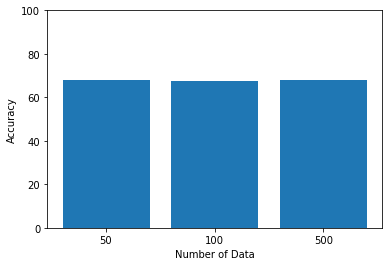

In [11]:
x = np.arange(3)
testCase_num = ['50', '100', '500']
values = [(acc_50 / len(case_50)) * 100, (acc_100 / len(case_100)) * 100, (acc_500 / len(case_500)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Number of Data')
plt.ylabel('Accuracy')

plt.show()

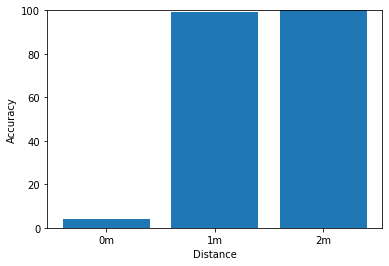

In [12]:
x = np.arange(3)
testCase_num = ['0m', '1m', '2m']
values = [(acc_0 / len(case_0)) * 100, (acc_1 / len(case_1)) * 100, (acc_2 / len(case_2)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Distance')
plt.ylabel('Accuracy')

plt.show()

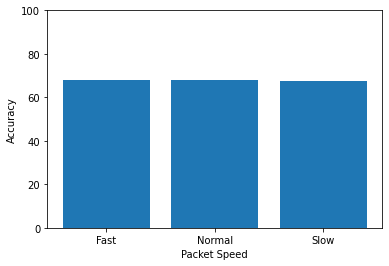

In [13]:
x = np.arange(3)
testCase_num = ['Fast', 'Normal', 'Slow']
values = [(acc_fast / len(case_fast)) * 100, (acc_normal / len(case_normal)) * 100, (acc_slow / len(case_slow)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Packet Speed')
plt.ylabel('Accuracy')

plt.show()